In [1]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch, torchvision
from torchvision import models
import torchvision.transforms as transforms
from torchinfo import summary

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

## Question 1

ref:

- https://medium.com/data-science-bootcamp/transfer-learning-with-pytorch-code-snippet-load-a-pretrained-model-900374950004

- https://towardsdatascience.com/fine-tuning-pre-trained-model-vgg-16-1277268c537f

- https://www.learnpytorch.io/06_pytorch_transfer_learning/#34-freezing-the-base-model-and-changing-the-output-layer-to-suit-our-needs


In [3]:
## Loading CIFAR-10 dataset

#transform = transforms.Compose(
#    [transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),]
)

#transform = torchvision.models.SqueezeNet1_0_Weights.DEFAULT.transforms()

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train, val = torch.utils.data.random_split(trainset, [0.7, 0.3])

trainloader = torch.utils.data.DataLoader(train, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

valloader = torch.utils.data.DataLoader(val, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 
           'ship', 'truck')

100%|██████████| 170498071/170498071 [00:01<00:00, 90831601.52it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
t, l = train[0]
t.size()

torch.Size([3, 224, 224])

### SqueezeNet

https://pytorch.org/hub/pytorch_vision_squeezenet/

In [5]:
squeezenet = torch.hub.load('pytorch/vision:v0.10.0', 'squeezenet1_0', pretrained=True)
squeezenet.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth
100%|██████████| 4.78M/4.78M [00:00<00:00, 60.6MB/s]


SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [6]:
old_seq = squeezenet.classifier

In [7]:
old_seq

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Conv2d(512, 1000, kernel_size=(1, 1), stride=(1, 1))
  (2): ReLU(inplace=True)
  (3): AdaptiveAvgPool2d(output_size=(1, 1))
)

In [8]:
for l in squeezenet.features.parameters():
    l.requires_grad = False

squeezenet.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(86528, 10),
)

summary(squeezenet, (10, 3, 224, 224), col_names=["output_size", "num_params", "trainable"])

/usr/local/lib/python3.10/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.10/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #                   Trainable
SqueezeNet                               [10, 10]                  --                        Partial
├─Sequential: 1-1                        [10, 512, 13, 13]         --                        False
│    └─Conv2d: 2-1                       [10, 96, 109, 109]        (14,208)                  False
│    └─ReLU: 2-2                         [10, 96, 109, 109]        --                        --
│    └─MaxPool2d: 2-3                    [10, 96, 54, 54]          --                        --
│    └─Fire: 2-4                         [10, 128, 54, 54]         --                        False
│    │    └─Conv2d: 3-1                  [10, 16, 54, 54]          (1,552)                   False
│    │    └─ReLU: 3-2                    [10, 16, 54, 54]          --                        --
│    │    └─Conv2d: 3-3                  [10, 64, 54, 54]          (1,088)                   False
│    │    └─R

In [9]:
if torch.cuda.is_available():  
  dev = "cuda:0" 
else:  
  dev = "cpu"  
device = torch.device(dev)  
print(device)
squeezenet = squeezenet.to(device)

cuda:0


In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(squeezenet.parameters(), lr=0.01)

In [12]:
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = squeezenet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1206.846
[1,  4000] loss: 1124.468
[1,  6000] loss: 1081.617
[1,  8000] loss: 1067.494
Finished Training


In [14]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in valloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = squeezenet(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the val images: {100 * correct // total} %')

Accuracy of the network on the val images: 77 %


In [18]:
# Fine Tuning (didn't work)
for l in squeezenet.features.parameters():
    l.requires_grad = True

for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = squeezenet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: nan
[1,  4000] loss: nan
[1,  6000] loss: nan
[1,  8000] loss: nan
Finished Training


In [17]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in valloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        # calculate outputs by running images through the network
        outputs = squeezenet(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the val images: {100 * correct // total} %')

Accuracy of the network on the val images: 10 %


## Question 3

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
lfwcrop = torchvision.datasets.ImageFolder('/content/drive/MyDrive/SU-MLAI/Computer Vision/assignment2/lfwcrop_color', transform=transform)
noisy_set = []
for im, l in lfwcrop:
  noisy_set.append(im + (0.1 * 1) * torch.randn(3, 64, 64))

class DualImageDataset(torch.utils.data.Dataset):
    def __init__(self, original, noisy):
        self.noisy = noisy
        self.original = original

    def __len__(self):
        return len(self.noisy)

    def __getitem__(self, index):
        noisy_image, original_image = self.noisy[index], self.original[index][0]
        return noisy_image, original_image

dataset = DualImageDataset(lfwcrop, noisy_set)

In [ ]:
len(lfwcrop), len(dataset)

(13238, 13238)

In [ ]:
n = len(dataset)

n_test = int(0.1 * n)
train_set, test_set = torch.utils.data.random_split(dataset, [n - n_test, n_test])

trainloader = torch.utils.data.DataLoader(train_set,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(test_set,
                                         shuffle=False, num_workers=2)

In [ ]:
class autoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 16, 3, padding = 1)
        self.pool = nn.MaxPool2d(2, 2, return_indices=True)
        self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding = 1)
        
        self.unpool = nn.MaxUnpool2d(2, 2)
        self.convT1 = nn.Conv2d(64, 32, 3, padding = 1)
        self.convT2 = nn.Conv2d(32, 16, 3, padding = 1)
        self.convT3 = nn.Conv2d(16, 3, 3, padding = 1)
        

    def forward(self, x):
        x, indices1 = self.pool(F.relu(self.conv1(x)))
        x, indices2 = self.pool(F.relu(self.conv2(x)))
        x, indices3 = self.pool(F.relu(self.conv3(x)))
        #x = F.relu(self.conv3(x))
        
        x = self.unpool(x, indices3)
        x = F.relu(self.convT1(x))
        x = self.unpool(x, indices2)
        x = F.relu(self.convT2(x))
        x = self.unpool(x, indices1)
        x = F.relu(self.convT3(x))
        return x
    
    
ae = autoEncoder()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(ae.parameters(),
                             lr = 1e-1,
                             weight_decay = 1e-8)

In [ ]:
class autoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv2d(3, 16, 3, padding = 1)
        self.pool = nn.MaxPool2d(2, 2, return_indices=True)
        self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding = 1)
        
        self.unpool = nn.MaxUnpool2d(2, 2)
        self.convT1 = nn.Conv2d(64, 32, 3, padding = 1)
        self.convT2 = nn.Conv2d(32, 16, 3, padding = 1)
        self.convT3 = nn.Conv2d(16, 3, 3, padding = 1)
        

    def forward(self, x):
        x, indices1 = self.pool(F.relu(self.conv1(x)))
        x, indices2 = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        
        x = F.relu(self.convT1(x))
        x = self.unpool(x, indices2)
        x = F.relu(self.convT2(x))
        x = self.unpool(x, indices1)
        x = F.relu(self.convT3(x))
        return x
    
    
ae = autoEncoder()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(ae.parameters(), lr = 0.001)

In [ ]:
for epoch in range(1):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = ae(inputs)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 0.008
[1,  4000] loss: 0.003
[1,  6000] loss: 0.002
[1,  8000] loss: 0.002
[1, 10000] loss: 0.002
Finished Training


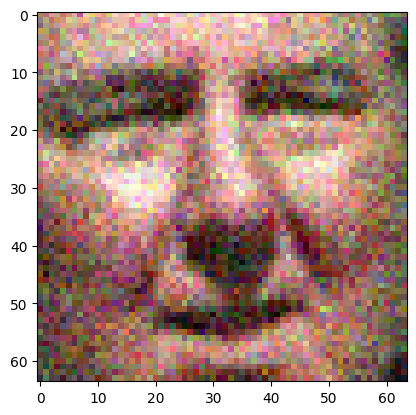

In [ ]:
test_img, test_label = test_set[17]
plt.imshow(test_img.permute(1, 2, 0))

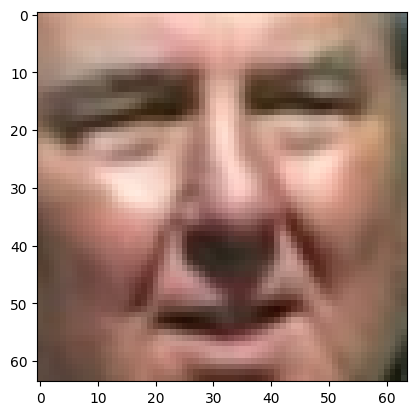

In [ ]:
plt.imshow(test_label.permute(1, 2, 0))

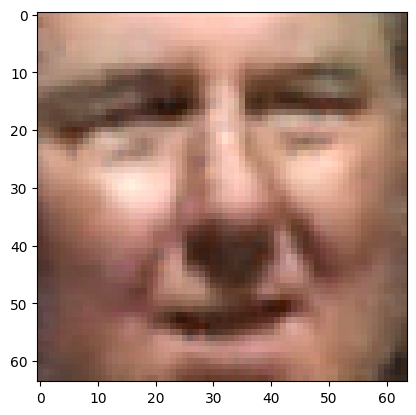

In [ ]:
plt.imshow(ae(test_img).detach().permute(1, 2, 0))
#ae(test_img_noisy)